In [19]:
import os
import time

import numpy as np
import pandas as pd

from scipy import stats
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree

import xgboost as xgb

pd.set_option('display.max_columns', None)

In [20]:
pcp_df = pd.read_csv('power_consumption_pred.csv')
cl_df = pd.read_csv('cell_level_data.csv')
bs_df = pd.read_csv('base_station_basic_info.csv')
ec_df = pd.read_csv('energy_consumption.csv')
ss_df = pd.read_csv('SampleSubmission.csv')

pcp_df.shape, cl_df.shape, bs_df.shape, ec_df.shape, ss_df.shape

((26139, 4), (125575, 10), (1217, 8), (92629, 3), (26139, 2))

In [21]:
ec_df.head(2)

,Time,BS,Energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335


In [22]:
cl_df.head(2)

,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode4,ESMode5,ESMode6
0,1/1/2023 1:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0
1,1/1/2023 2:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0


In [23]:
bs_df.head(2)

,BS,CellName,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower
0,B_0,Cell0,Type1,Mode2,365.0,20,4,6.875934
1,B_1,Cell0,Type2,Mode2,532.0,20,4,6.875934


In [24]:
pcp_df.head(2)

,Time,BS,Energy,w
0,2023-01-01 06:00:00,B_0,NaN,1
1,2023-01-01 11:00:00,B_0,NaN,1


In [25]:
pcp_df['w'].value_counts()

w
1    23189
5     2950
Name: count, dtype: int64

### Pre-Processing

In [26]:
def rename_columns(df):
    df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)
    return df

In [27]:
pcp_df = rename_columns(pcp_df)
cl_df = rename_columns(cl_df)
bs_df = rename_columns(bs_df)
ec_df = rename_columns(ec_df)

In [28]:
cl_df['time'] = pd.to_datetime(cl_df['time'])
ec_df['time'] = pd.to_datetime(ec_df['time'])
pcp_df['time'] = pd.to_datetime(pcp_df['time'])

In [29]:
cl_bs_df = cl_df.merge(bs_df, on=['bs', 'cellname'], how='left')
cl_bs_df.head(2)

,time,bs,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,rutype,mode,frequency,bandwidth,antennas,txpower
0,2023-01-01 01:00:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
1,2023-01-01 02:00:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934


In [30]:
cl_bs_df[cl_bs_df['bs'] == 'B_0']

,time,bs,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,rutype,mode,frequency,bandwidth,antennas,txpower
0,2023-01-01 01:00:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
1,2023-01-01 02:00:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
2,2023-01-01 03:00:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
3,2023-01-01 04:00:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
4,2023-01-01 05:00:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118787,2023-01-02 19:00:00,B_0,Cell1,0.206135,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504
118788,2023-01-02 20:00:00,B_0,Cell1,0.152981,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504
118789,2023-01-02 21:00:00,B_0,Cell1,0.150808,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504
118790,2023-01-02 22:00:00,B_0,Cell1,0.289731,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504


In [31]:
cl_bs_df.groupby("bs")['cellname'].nunique()

bs
B_0       2
B_1       1
B_10      2
B_100     1
B_1000    1
         ..
B_995     1
B_996     1
B_997     1
B_998     1
B_999     1
Name: cellname, Length: 1020, dtype: int64

In [32]:
cl_bs_df.groupby("bs")['cellname'].nunique().value_counts()

cellname
1    827
2    191
4      2
Name: count, dtype: int64

In [33]:
cl_bs_df = cl_bs_df.pivot(
    index=['time', 'bs'],
    columns=['cellname'],
    values=['load', 'esmode1', 'esmode2', 'esmode3',
       'esmode4', 'esmode5', 'esmode6', 'frequency',
       'bandwidth', 'antennas', 'txpower'],
).reset_index()

cl_bs_df.columns = ['_'.join([str(i) for i in x]) for x in cl_bs_df.columns]
cl_bs_df.columns = cl_bs_df.columns.str.strip('_')
cl_bs_df = rename_columns(cl_bs_df)
cl_bs_df = cl_bs_df.merge(bs_df.groupby('bs')[['rutype', 'mode']].first().reset_index(), on='bs', how='left')

In [34]:
cl_bs_df.head(2)

,time,bs,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3,rutype,mode
0,2023-01-01 01:00:00,B_0,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2
1,2023-01-01 01:00:00,B_1,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type2,Mode2


In [36]:
cl_bs_df.head(2)

,time,bs,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3,rutype,mode
0,2023-01-01 01:00:00,B_0,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2
1,2023-01-01 01:00:00,B_1,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type2,Mode2


In [37]:
ec_df.head(2)

,time,bs,energy
0,2023-01-01 01:00:00,B_0,64.275037
1,2023-01-01 02:00:00,B_0,55.904335


In [38]:
df = cl_bs_df.merge(ec_df, on=['time', 'bs'], how='left')

In [39]:
df.head(2)

,time,bs,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3,rutype,mode,energy
0,2023-01-01 01:00:00,B_0,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2,64.275037
1,2023-01-01 01:00:00,B_1,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type2,Mode2,18.086697


In [40]:
df['energy'].isna().value_counts()

energy
False    92629
True     26139
Name: count, dtype: int64

In [41]:
df['split'] = df['energy'].isna().apply(lambda x: 'test' if x == True else 'train')

In [42]:
ss_df.shape

(26139, 2)

In [43]:
ec_df.shape

(92629, 3)

### Base Model Building

In [44]:
train_data = df[df['split'] =='train']
test_data = df[df['split'] =='test']

train_data.shape, test_data.shape

((92629, 50), (26139, 50))

In [45]:
def feature_enginning(train_df, valid_df, test_df):

    train_df['hour'] = train_df['time'].dt.hour
    valid_df['hour'] = valid_df['time'].dt.hour
    test_df['hour'] = test_df['time'].dt.hour


    train_df['split'] = 'train'
    valid_df['split'] = 'valid'
    test_df['split'] = 'test'

    df = pd.concat([train_df, valid_df, test_df])
    df['bs_en'] = df['bs'].apply(lambda x: int(x.strip('B_')))

    df = pd.get_dummies(df, columns=['rutype',  'mode', 'hour'])

    df.sort_values(['time', 'bs'], inplace=True)


    train_df = df[df['split'] =='train']
    valid_df = df[df['split'] =='valid']
    test_df = df[df['split'] =='test']

    return train_df, valid_df, test_df

In [46]:
target_col = 'energy'
drop_cols = ['time', 'bs', 'split', target_col]

In [47]:
kf = model_selection.KFold(n_splits=5)
kf = kf.split(X=train_data)

oof_valid_preds = np.zeros(train_data.shape[0], )
test_preds_list = []

for i, (train_idx, valid_idx) in enumerate(kf):

    train_df = train_data.iloc[train_idx]
    valid_df = train_data.iloc[valid_idx]
    test_df = test_data.copy()

    train_df, valid_df, test_df = feature_enginning(train_df=train_df, valid_df=valid_df, test_df=test_df)
    train_cols = [col for col in train_df.columns if col not in drop_cols]

    X_train, y_train = train_df[train_cols], train_df[target_col]
    X_valid, y_valid = valid_df[train_cols], valid_df[target_col]
    X_test = test_df[train_cols]


    model = xgb.XGBRegressor(random_state = 0)

    # early_stopping_callback = lgb.early_stopping(100, first_metric_only=True, verbose=False)
    # verbose_callback = lgb.log_evaluation(100)

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        # callbacks=[early_stopping_callback, verbose_callback],
    )

    valid_preds = model.predict(X_valid)
    test_preds = model.predict(X_test)

    val_score = metrics.mean_absolute_error(y_valid, valid_preds)
    oof_valid_preds[valid_idx] = valid_preds
    test_preds_list.append(test_preds)

    print("=*"*50)
    print(f"Fold : {i}")
    print(f"Valid score : ", val_score)

oof_score = metrics.mean_absolute_error(train_data[target_col], oof_valid_preds)
print("_-*"*50)
print(f"OOF score : ", oof_score)

C:\Users\user\AppData\Local\Temp\ipykernel_6224\4044124334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['hour'] = train_df['time'].dt.hour
C:\Users\user\AppData\Local\Temp\ipykernel_6224\4044124334.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['hour'] = valid_df['time'].dt.hour
C:\Users\user\AppData\Local\Temp\ipykernel_6224\4044124334.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

[0]	validation_0-rmse:21.43283
[1]	validation_0-rmse:15.30438
[2]	validation_0-rmse:11.10485
[3]	validation_0-rmse:8.28636
[4]	validation_0-rmse:6.46363
[5]	validation_0-rmse:5.33804
[6]	validation_0-rmse:4.65005
[7]	validation_0-rmse:4.25833
[8]	validation_0-rmse:4.00257
[9]	validation_0-rmse:3.84937
[10]	validation_0-rmse:3.75584
[11]	validation_0-rmse:3.70010
[12]	validation_0-rmse:3.65273
[13]	validation_0-rmse:3.58804
[14]	validation_0-rmse:3.54603
[15]	validation_0-rmse:3.52610
[16]	validation_0-rmse:3.44846
[17]	validation_0-rmse:3.43166
[18]	validation_0-rmse:3.39510
[19]	validation_0-rmse:3.30605
[20]	validation_0-rmse:3.23685
[21]	validation_0-rmse:3.22769
[22]	validation_0-rmse:3.16839
[23]	validation_0-rmse:3.11989
[24]	validation_0-rmse:3.10942
[25]	validation_0-rmse:3.09987
[26]	validation_0-rmse:3.07595
[27]	validation_0-rmse:3.06935
[28]	validation_0-rmse:3.06127
[29]	validation_0-rmse:3.01967
[30]	validation_0-rmse:3.01148
[31]	validation_0-rmse:2.99338
[32]	validation

C:\Users\user\AppData\Local\Temp\ipykernel_6224\4044124334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['hour'] = train_df['time'].dt.hour
C:\Users\user\AppData\Local\Temp\ipykernel_6224\4044124334.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['hour'] = valid_df['time'].dt.hour
C:\Users\user\AppData\Local\Temp\ipykernel_6224\4044124334.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

[0]	validation_0-rmse:21.74256
[1]	validation_0-rmse:15.71358
[2]	validation_0-rmse:11.58498
[3]	validation_0-rmse:8.80272
[4]	validation_0-rmse:7.07838
[5]	validation_0-rmse:5.98648
[6]	validation_0-rmse:5.30322
[7]	validation_0-rmse:4.59385
[8]	validation_0-rmse:4.35617
[9]	validation_0-rmse:4.12384
[10]	validation_0-rmse:3.88633
[11]	validation_0-rmse:3.79931
[12]	validation_0-rmse:3.65624
[13]	validation_0-rmse:3.63055
[14]	validation_0-rmse:3.52916
[15]	validation_0-rmse:3.50016
[16]	validation_0-rmse:3.47583
[17]	validation_0-rmse:3.44699
[18]	validation_0-rmse:3.36366
[19]	validation_0-rmse:3.35221
[20]	validation_0-rmse:3.34341
[21]	validation_0-rmse:3.26951
[22]	validation_0-rmse:3.25810
[23]	validation_0-rmse:3.15988
[24]	validation_0-rmse:3.11259
[25]	validation_0-rmse:3.10526
[26]	validation_0-rmse:3.07900
[27]	validation_0-rmse:3.07314
[28]	validation_0-rmse:3.04842
[29]	validation_0-rmse:3.03919
[30]	validation_0-rmse:3.01543
[31]	validation_0-rmse:2.94580
[32]	validation

C:\Users\user\AppData\Local\Temp\ipykernel_6224\4044124334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['hour'] = train_df['time'].dt.hour
C:\Users\user\AppData\Local\Temp\ipykernel_6224\4044124334.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['hour'] = valid_df['time'].dt.hour
C:\Users\user\AppData\Local\Temp\ipykernel_6224\4044124334.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

[0]	validation_0-rmse:22.17134
[1]	validation_0-rmse:15.91494
[2]	validation_0-rmse:11.59903
[3]	validation_0-rmse:8.70825
[4]	validation_0-rmse:6.77469
[5]	validation_0-rmse:5.53806
[6]	validation_0-rmse:4.77250
[7]	validation_0-rmse:4.28975
[8]	validation_0-rmse:4.00052
[9]	validation_0-rmse:3.72203
[10]	validation_0-rmse:3.61630
[11]	validation_0-rmse:3.55504
[12]	validation_0-rmse:3.46852
[13]	validation_0-rmse:3.43568
[14]	validation_0-rmse:3.40732
[15]	validation_0-rmse:3.38790
[16]	validation_0-rmse:3.30750
[17]	validation_0-rmse:3.28769
[18]	validation_0-rmse:3.25680
[19]	validation_0-rmse:3.24247
[20]	validation_0-rmse:3.22416
[21]	validation_0-rmse:3.21896
[22]	validation_0-rmse:3.17499
[23]	validation_0-rmse:3.13236
[24]	validation_0-rmse:3.13554
[25]	validation_0-rmse:3.12938
[26]	validation_0-rmse:3.12368
[27]	validation_0-rmse:3.10889
[28]	validation_0-rmse:3.08200
[29]	validation_0-rmse:3.06360
[30]	validation_0-rmse:2.99690
[31]	validation_0-rmse:2.99619
[32]	validation

C:\Users\user\AppData\Local\Temp\ipykernel_6224\4044124334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['hour'] = train_df['time'].dt.hour
C:\Users\user\AppData\Local\Temp\ipykernel_6224\4044124334.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['hour'] = valid_df['time'].dt.hour
C:\Users\user\AppData\Local\Temp\ipykernel_6224\4044124334.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

[0]	validation_0-rmse:22.63767
[1]	validation_0-rmse:16.25684
[2]	validation_0-rmse:11.84561
[3]	validation_0-rmse:8.85002
[4]	validation_0-rmse:6.88010
[5]	validation_0-rmse:5.59898
[6]	validation_0-rmse:4.81151
[7]	validation_0-rmse:4.32528
[8]	validation_0-rmse:4.00173
[9]	validation_0-rmse:3.78910
[10]	validation_0-rmse:3.68596
[11]	validation_0-rmse:3.60170
[12]	validation_0-rmse:3.54655
[13]	validation_0-rmse:3.50793
[14]	validation_0-rmse:3.48141
[15]	validation_0-rmse:3.39562
[16]	validation_0-rmse:3.37906
[17]	validation_0-rmse:3.36001
[18]	validation_0-rmse:3.31775
[19]	validation_0-rmse:3.30776
[20]	validation_0-rmse:3.24967
[21]	validation_0-rmse:3.21596
[22]	validation_0-rmse:3.20584
[23]	validation_0-rmse:3.20063
[24]	validation_0-rmse:3.13611
[25]	validation_0-rmse:3.08825
[26]	validation_0-rmse:3.08101
[27]	validation_0-rmse:3.07199
[28]	validation_0-rmse:3.06223
[29]	validation_0-rmse:3.06104
[30]	validation_0-rmse:3.04818
[31]	validation_0-rmse:3.03007
[32]	validation

C:\Users\user\AppData\Local\Temp\ipykernel_6224\4044124334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['hour'] = train_df['time'].dt.hour
C:\Users\user\AppData\Local\Temp\ipykernel_6224\4044124334.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['hour'] = valid_df['time'].dt.hour
C:\Users\user\AppData\Local\Temp\ipykernel_6224\4044124334.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

[0]	validation_0-rmse:21.81140
[1]	validation_0-rmse:15.51276
[2]	validation_0-rmse:11.20808
[3]	validation_0-rmse:8.32548
[4]	validation_0-rmse:6.44158
[5]	validation_0-rmse:5.23730
[6]	validation_0-rmse:4.51813
[7]	validation_0-rmse:4.12555
[8]	validation_0-rmse:3.88645
[9]	validation_0-rmse:3.76069
[10]	validation_0-rmse:3.64901
[11]	validation_0-rmse:3.59583
[12]	validation_0-rmse:3.52959
[13]	validation_0-rmse:3.49088
[14]	validation_0-rmse:3.46722
[15]	validation_0-rmse:3.44467
[16]	validation_0-rmse:3.37408
[17]	validation_0-rmse:3.31478
[18]	validation_0-rmse:3.25505
[19]	validation_0-rmse:3.21140
[20]	validation_0-rmse:3.19625
[21]	validation_0-rmse:3.18498
[22]	validation_0-rmse:3.14432
[23]	validation_0-rmse:3.13466
[24]	validation_0-rmse:3.12368
[25]	validation_0-rmse:3.07104
[26]	validation_0-rmse:3.03456
[27]	validation_0-rmse:3.02770
[28]	validation_0-rmse:2.99152
[29]	validation_0-rmse:2.97254
[30]	validation_0-rmse:2.96594
[31]	validation_0-rmse:2.96100
[32]	validation

In [48]:
test_preds_list

[array([13.734243, 46.079796, 14.942588, ..., 17.55859 , 20.79212 ,
        37.3154  ], dtype=float32),
 array([14.563181, 45.760265, 16.548166, ..., 17.665928, 21.507322,
        37.430256], dtype=float32),
 array([14.774462, 45.924103, 16.711784, ..., 17.917898, 20.951012,
        35.53078 ], dtype=float32),
 array([14.268333, 46.00799 , 18.71578 , ..., 17.45502 , 21.285742,
        37.037365], dtype=float32),
 array([14.3604355, 45.318283 , 17.928173 , ..., 18.75007  , 21.384245 ,
        36.749935 ], dtype=float32)]

In [49]:
test_preds_mean = np.mean(test_preds_list, axis=0)

In [50]:
test_preds_mean

array([14.340131, 45.81809 , 16.9693  , ..., 17.869503, 21.184088,
       36.812748], dtype=float32)

In [51]:
test_preds_mean.shape

(26139,)

In [52]:
test_data.shape

(26139, 50)

In [53]:
test_data['Energy'] = test_preds_mean

C:\Users\user\AppData\Local\Temp\ipykernel_6224\3896984337.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Energy'] = test_preds_mean


<Axes: >

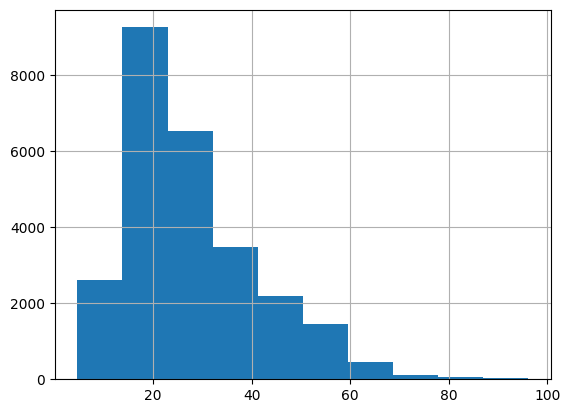

In [55]:
test_data['Energy'].hist()

In [57]:
ss_df.head(2)

,ID,Energy
0,2023-01-01 06:00:00_B_0,0
1,2023-01-01 11:00:00_B_0,0


In [59]:
test_data['ID'] = test_data['time'].astype('str') + '_' + test_data['bs']

C:\Users\user\AppData\Local\Temp\ipykernel_6224\2173734627.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ID'] = test_data['time'].astype('str') + '_' + test_data['bs']


In [60]:
test_data[['ID', 'Energy']]

,ID,Energy
3,2023-01-01 01:00:00_B_100,14.340131
8,2023-01-01 01:00:00_B_105,45.818089
10,2023-01-01 01:00:00_B_107,16.969299
15,2023-01-01 01:00:00_B_111,37.357819
18,2023-01-01 01:00:00_B_114,23.375555
...,...,...
118757,2023-01-08 00:00:00_B_786,24.007381
118761,2023-01-08 00:00:00_B_790,20.772528
118762,2023-01-08 00:00:00_B_791,17.869503
118763,2023-01-08 00:00:00_B_792,21.184088


In [61]:
ss_df = ss_df[['ID']]
ss_df = ss_df.merge(test_data[['ID', 'Energy']], on='ID', how='left')

In [62]:
ss_df.head(2)

,ID,Energy
0,2023-01-01 06:00:00_B_0,58.990273
1,2023-01-01 11:00:00_B_0,72.415306


In [63]:
ss_df.to_csv("submission.csv", index=False)